In [608]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

import torch.nn.functional as F

from sklearn.manifold import TSNE

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [609]:
base_dir = '../Data_Generation/Data_files/labeled_points/'
base_fp = base_dir + '../points/sl2_Z_3s.csv'
test_fp = base_dir + 'sl2_Z_3s_test.csv'
train_fp = base_dir + 'sl2_Z_3s_train.csv'

In [1197]:
MAX_REWARD = 100
STEP_PENALTY = -1

def get_reward_log(state: torch.Tensor) -> tuple[float, bool]:
    if state.equal(torch.eye(2)):
        return (MAX_REWARD, True)
    l2_log = -torch.log((state**2).sum()).item() + 20
    return (l2_log, False)

def get_reward(state: torch.Tensor) -> tuple[int, bool]:
    if state.equal(torch.eye(2, dtype=torch.float64)):
        return (MAX_REWARD, True)
    return (STEP_PENALTY, False)

### Network Architecture
$4\times1\to$ hidden layers $\to 4\times 1$

In [1077]:
class DeepQModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepQModel, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_size, 128, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(128, 64, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(64, 16, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(16, output_size, dtype=torch.float64),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.stack(x)

In [1322]:
MATRIX_SIZE = 4     # i.e. 2x2
NUM_GENERATORS = 4  # Number of generators in group (including inverses)

class DeepQAgent:
    def __init__(self, learning_rate: float, epsilon: float, epsilon_decay: float, 
                 min_epsilon: float, discount_factor: float, batch_size: int, memory_capacity: int):
        # Initialize main an target models and set weights to be equivalent
        self.mainModel = DeepQModel(MATRIX_SIZE, NUM_GENERATORS)
        self.targetModel = DeepQModel(MATRIX_SIZE, NUM_GENERATORS)
        self.targetModel.eval()
        
        # TODO: check if this works
        self.copy_main_to_target()

        # Initialize Hyperparameters
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity
        self.replay_cnt = 0

        # Optimization initialization
        self.optimizer = optim.Adam(self.mainModel.parameters())#, lr=self.learning_rate)

        # Experience Replay Buffers and parameters
        self.memory = deque()
       
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        return self.mainModel.forward(x.flatten())

    def epsilon_greedy_search(self, state):
        if torch.rand(1) <= self.epsilon:
            return int(torch.randint(0, NUM_GENERATORS, (1,)).item())
        return int(self.mainModel.forward(state).argmax().item())

    def copy_main_to_target(self):
        self.targetModel.load_state_dict(self.mainModel.state_dict())

    # Citing Algorithm 1 https://arxiv.org/pdf/1312.5602.pdf
    def replay(self):
        # Ensure there is enough memory for a full batch
        if len(self.memory) <  self.batch_size:
            print('Skipping replay, not enough memory')
            return
        self.replay_cnt += 1

        # Random sample a batch_size's worth of memory
        minibatch = random.sample(self.memory, self.batch_size)

        # Vectorizing data
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.stack(states)
        next_states = torch.stack(next_states)
        actions = torch.tensor(actions, dtype=torch.int64) # Stores matrices multiplied by, NOT index
        rewards = torch.tensor(rewards, dtype=torch.float64)
        dones = torch.tensor(dones, dtype=torch.float64)
        
        # Bellman Equation: (Reward + discount_factor * state_prediction)
        next_q_predictions, _ = self.targetModel.forward(next_states.reshape(-1, 4)).max(dim=1)
        q_values = self.mainModel.forward(states.reshape(-1, 4))[torch.arange(0, states.shape[0]), actions]
        bellmans = rewards + (1 - dones) * self.discount_factor * next_q_predictions

        # Calculate loss and perform optimization step
        loss = F.mse_loss(q_values, bellmans)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Perform Epsilon decay for each training step
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
        
    def remember(self, state, action, reward, next_state, done: bool):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_capacity:
            self.memory.popleft()



In [1323]:
class DeepQAgentTrainer: 
    def __init__(self, agent: DeepQAgent, actions: list[torch.Tensor], train_matrices: torch.Tensor, batch_size: int):
        self.agent = agent
        self.actions = actions
        self.train_matrices = train_matrices
        self.batch_size = batch_size
        self.total_episodes = 0
    
    def play(self, episodes: int, replay_periodicity: int, max_game_len: int):
        '''
        episodes - The number of episodes or 'games' played by the agent to train
        replay_periodicity - The number of episodes after which weights will be updated
        '''
        sample_idxs = torch.randint(0, self.train_matrices.shape[0], (episodes, ))
        for episode in torch.arange(0, episodes):
            print(f"Episode {episode+1}/{episodes}:")
            mat = self.train_matrices[sample_idxs[episode]]

            steps = 0
            done = False
            while steps < max_game_len and not done:
                pred_action_idx = self.agent.epsilon_greedy_search(mat.flatten()) # self.agent.predict(mat).argmax(dim=0)
                action = self.actions[pred_action_idx]
                next_mat = torch.matmul(mat, action)
                reward, done = get_reward(next_mat)
                self.agent.remember(mat, pred_action_idx, reward, next_mat, done)

                # Update necessary vars for next iteration
                mat = next_mat
                steps += 1
            
            # Copy weights if necessary
            if episode % 10 == 0 and episode != 0:
                self.agent.copy_main_to_target()
                
            print(f"\tIdentity Found: {done}")
            self.agent.replay()
        
        return self.agent.memory 

    def play_dbg(self, start: torch.Tensor, max_game_len: int):
        '''
        episodes - The number of episodes or 'games' played by the agent to train
        replay_periodicity - The number of episodes after which weights will be updated
        '''
        walk = []
        rewards = []
        acts = []
        mat = start

        steps = 0
        done = False
        while steps < max_game_len and not done:
            pred = self.agent.epsilon_greedy_search(mat.flatten())
            action = self.actions[pred]
            next_mat = torch.matmul(mat, action)
            reward, done = get_reward(mat)
            self.agent.remember(mat, pred, reward, next_mat, done)

            # Update necessary vars for next iteration
            walk.append(mat)
            rewards.append(reward)
            acts.append(pred)
            mat = next_mat
            steps += 1
        self.agent.replay()
        
        return (walk, rewards, acts)


In [1080]:
# Load data
df = pd.read_csv(base_fp)
train_df = pd.read_csv(train_fp)
test_df = pd.read_csv(test_fp)

xs_data = pd.read_csv(base_dir + 'sl2_Z_3s_bfs_xtra_small.csv')
s_data = pd.read_csv(base_dir + 'sl2_Z_3s_bfs_small.csv')
m_data = pd.read_csv(base_dir + 'sl2_Z_3s_bfs_medium.csv')
l_data = pd.read_csv(base_dir + 'sl2_Z_3s_bfs_large.csv')
xl_data = pd.read_csv(base_dir + 'sl2_Z_3s_bfs_xtra_large.csv')


In [1081]:
# Converting Sized DataFrames to matrices
xs_data = torch.tensor(xs_data.values, dtype=torch.float64)
xs_mats = xs_data[:, :4].reshape(-1, 2, 2)
xs_labels = xs_data[:, 4]

s_data = torch.tensor(s_data.values, dtype=torch.float64)
s_mats = s_data[:, :4].reshape(-1, 2, 2)
s_labels = s_data[:, 4]

m_data = torch.tensor(m_data.values, dtype=torch.float64)
m_mats = m_data[:, :4].reshape(-1, 2, 2)
m_labels = m_data[:, 4]

l_data = torch.tensor(l_data.values, dtype=torch.float64)
l_mats = l_data[:, :4].reshape(-1, 2, 2)
l_labels = l_data[:, 4]

xl_data = torch.tensor(xl_data.values, dtype=torch.float64)
xl_mats = xl_data[:, :4].reshape(-1, 2, 2)
xl_labels = xl_data[:, 4]

In [1082]:
# All matrices
matrices_all = torch.tensor(df.values, dtype=torch.float64).reshape(100000, 2, 2)

# Training matrices and labels
train_data = torch.tensor(train_df.values, dtype=torch.float64)
labels_train = train_data[:,-1]
matrices_train = train_data[:,0:-2].reshape(train_data.shape[0], 2, 2)

# Testing matrices and labels
test_data = torch.tensor(test_df.values, dtype=torch.float64)
labels_test = test_data[:,-1]
matrices_test = test_data[:,0:-2].reshape(test_data.shape[0], 2, 2)

# Visualization vectors
basis_vec = torch.tensor([[1, 0]], dtype=torch.float64)
vecs_all = matrices_all.matmul(basis_vec.T)
vecs_train = matrices_train.matmul(basis_vec.T)
vecs_test = matrices_test.matmul(basis_vec.T)
x_train = vecs_train[:, 0]
x_test = vecs_test[:, 0]
y_train = vecs_train[:, 1]
y_test = vecs_test[:, 1]

# Training data masks to zoom plot
train_mask1 = x_train < 500
train_mask2 = x_train > -500
train_mask3 = y_train < 500
train_mask4 = y_train > -500
train_mask = train_mask1 & train_mask2 & train_mask3 & train_mask4

# Testing data mask to zoom plot
test_mask1 = x_test < 500
test_mask2 = x_test > -500
test_mask3 = y_test < 500
test_mask4 = y_test > -500
test_mask = test_mask1 & test_mask2 & test_mask3 & test_mask4

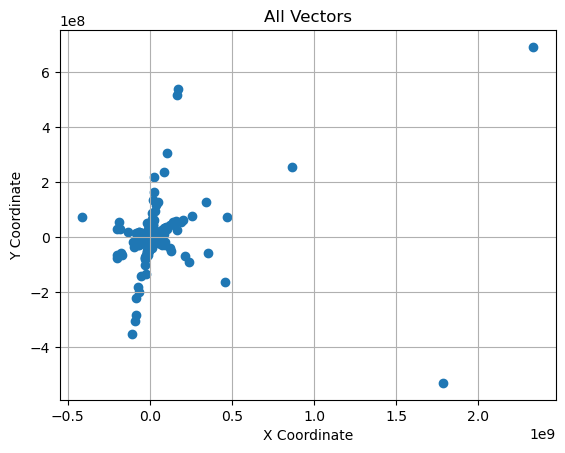

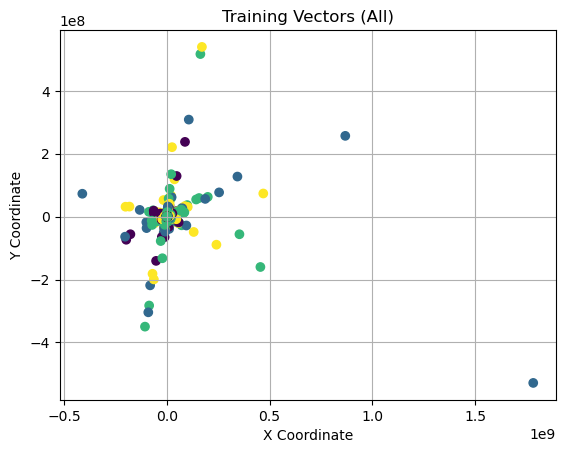

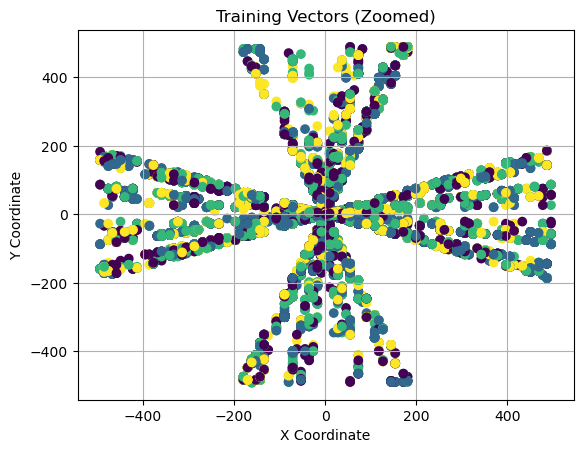

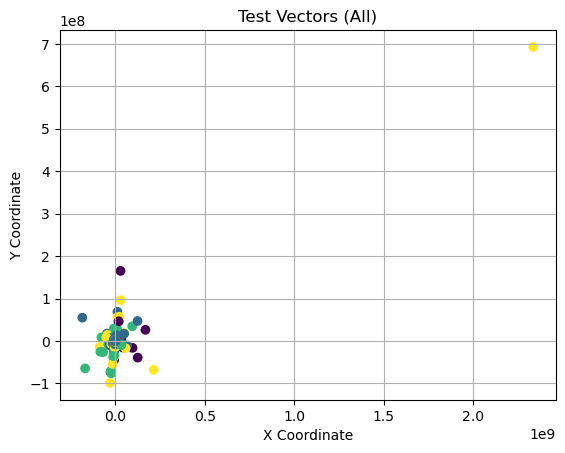

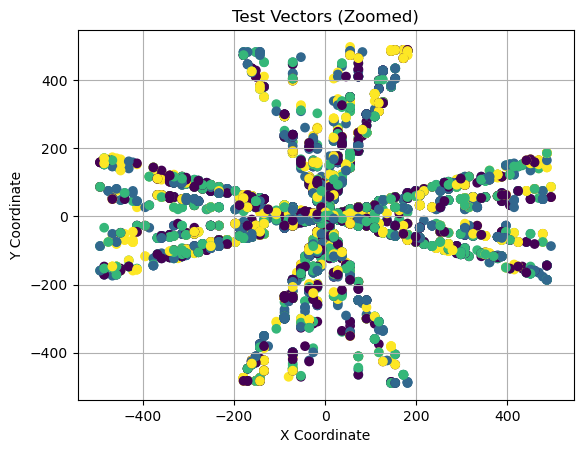

In [1320]:
# Plot data
plt.scatter(vecs_all[:, 0], vecs_all[:, 1])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('All Vectors')
plt.grid(True)
plt.show()

plt.scatter(x_train, y_train, c=labels_train)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Training Vectors (All)')
plt.grid(True)
plt.show()

plt.scatter(x_train[train_mask], y_train[train_mask], c=labels_train[train_mask.flatten()])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Training Vectors (Zoomed)')
plt.grid(True)
plt.show()

plt.scatter(x_test, y_test, c=labels_test)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Test Vectors (All)')
plt.grid(True)
plt.show()

plt.scatter(x_test[test_mask], y_test[test_mask], c=labels_test[test_mask.flatten()])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Test Vectors (Zoomed)')
plt.grid(True)
plt.show()

In [1084]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
tsne_out = tsne.fit_transform(matrices_train.reshape(matrices_train.shape[0], 4).numpy())

KeyboardInterrupt: 

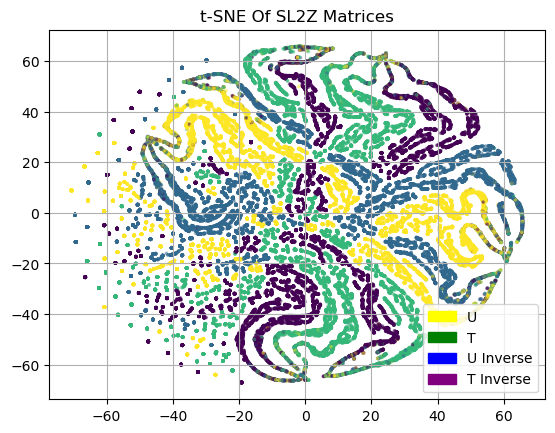

tensor(3., dtype=torch.float64)


In [ ]:
plt.scatter(tsne_out[:,0], tsne_out[:,1], c=labels_train, cmap='viridis', s=3, alpha=.4)
plt.title('t-SNE Of SL2Z Matrices')
plt.legend(handles=[mpatches.Patch(color='yellow', label='U'),
                    mpatches.Patch(color='Green', label='T'),
                    mpatches.Patch(color='Blue', label='U Inverse'),
                    mpatches.Patch(color='Purple', label='T Inverse')])
plt.grid(True)
plt.show()
print(labels_train[0])

In [1092]:
dqa = DeepQAgent(learning_rate=0.001, epsilon=1.0, epsilon_decay=0.999, min_epsilon=.01, discount_factor=.99, batch_size=25, memory_capacity=10_000)

In [1093]:
U = torch.tensor([[1, 3], [0, 1]], dtype=torch.float64)
T = torch.tensor([[1, 0], [3, 1]], dtype=torch.float64)
U_INV = U.inverse()
T_INV = T.inverse()

generators = [U, T, U_INV, T_INV]

# matrices_train.reshape(matrices_train.shape[0], 4)
agent_trainer = DeepQAgentTrainer(dqa, generators, xs_mats, 25)

In [1094]:
mem = agent_trainer.play(100, 10, 20)

Episode 1/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 2/100:
	Identity Found: False
Episode 3/100:
	Identity Found: True
Episode 4/100:
	Identity Found: True
Episode 5/100:
	Identity Found: False
Episode 6/100:
	Identity Found: False
Episode 7/100:
	Identity Found: False
Episode 8/100:
	Identity Found: False
Episode 9/100:
	Identity Found: False
Episode 10/100:
	Identity Found: False
Episode 11/100:
	Identity Found: False
Episode 12/100:
	Identity Found: False
Episode 13/100:
	Identity Found: False
Episode 14/100:
	Identity Found: False
Episode 15/100:
	Identity Found: False
Episode 16/100:
	Identity Found: False
Episode 17/100:
	Identity Found: False
Episode 18/100:
	Identity Found: False
Episode 19/100:
	Identity Found: False
Episode 20/100:
	Identity Found: False
Episode 21/100:
	Identity Found: False
Episode 22/100:
	Identity Found: False
Episode 23/100:
	Identity Found: True
Episode 24/100:
	Identity Found: False
Episode 25/100:
	Identity Found: False
Ep

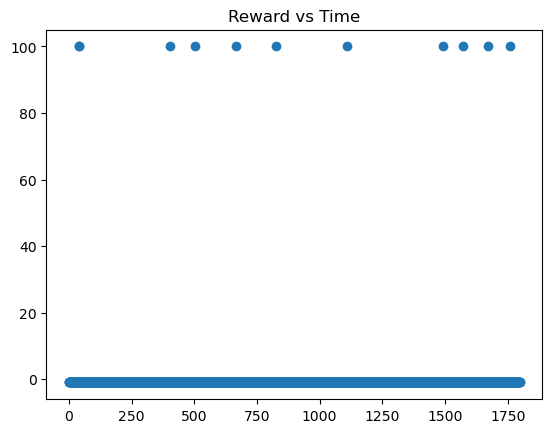

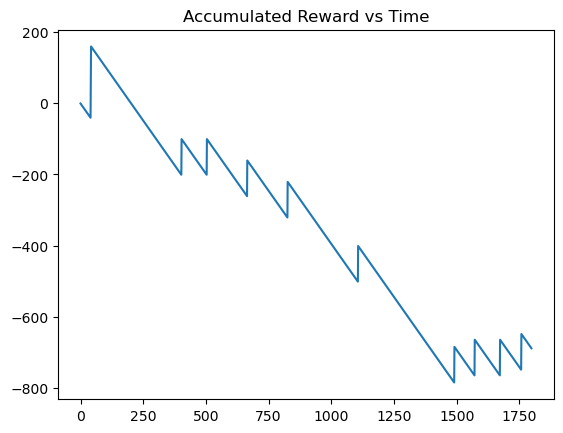

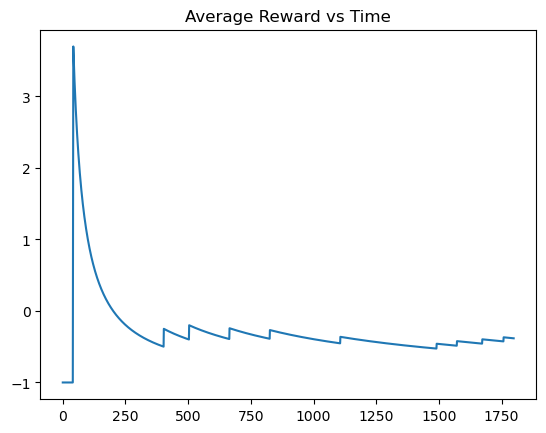

In [1095]:
rs = []
cumulative_rs = []
avg_rs = []
acc = 0
for idx, m in enumerate(mem):
    acc += m[2]
    cumulative_rs.append(acc)
    avg_rs.append(acc/(idx+1))
    rs.append(m[2])

plt.scatter(torch.arange(0, len(rs)), rs)
plt.title('Reward vs Time')
plt.show()

plt.plot(torch.arange(0, len(cumulative_rs)), cumulative_rs)
plt.title('Accumulated Reward vs Time')
plt.show()

plt.plot(torch.arange(0, len(avg_rs)), avg_rs)
plt.title('Average Reward vs Time')
plt.show()

In [1096]:
dqa.predict(U.flatten())

tensor([0.3967, 0.2448, 0.1344, 0.2144], dtype=torch.float64,
       grad_fn=<AddBackward0>)

In [1097]:
q_vals, pred_action_idx = dqa.mainModel.forward(matrices_train.reshape(69999, 4)).max(dim=1, keepdim=True)
xs_qs, xs_pred_acts = dqa.mainModel.forward(xs_mats.reshape(-1, 4)).max(dim=1, keepdim=True)

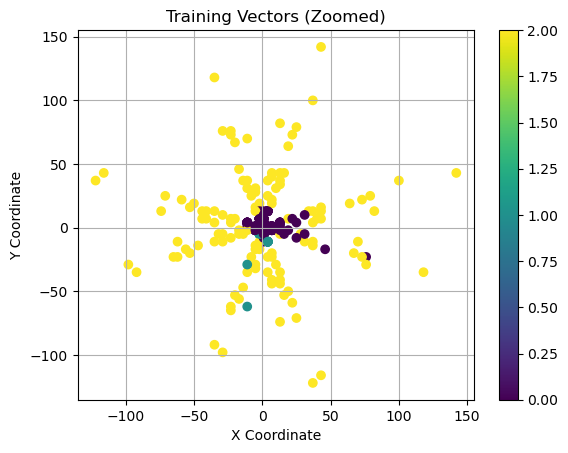

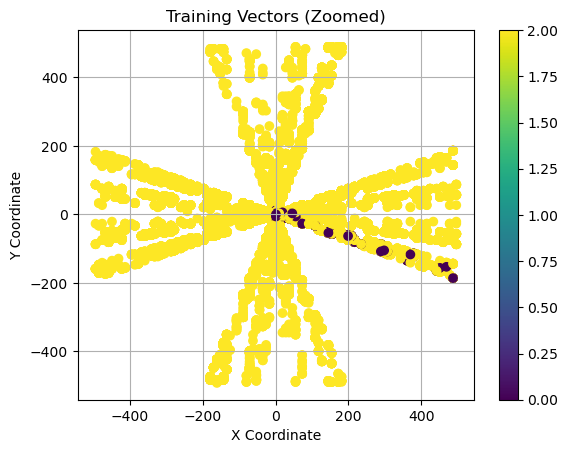

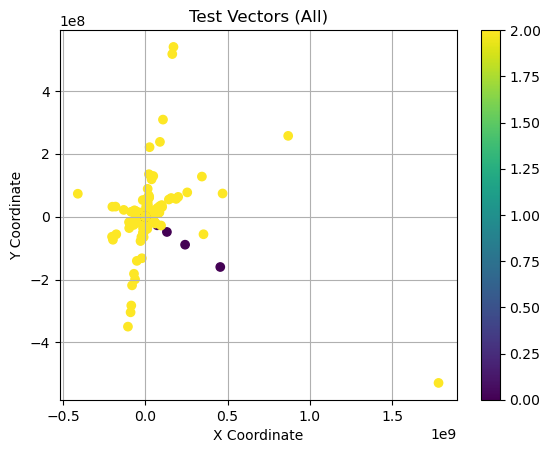

In [1098]:
b = torch.tensor([[1], [1]], dtype=torch.float64)
xs_vecs = b.T.matmul(xs_mats).flatten(start_dim=1)

plt.scatter(xs_vecs[:, 0], xs_vecs[:, 1], c=xs_pred_acts)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Training Vectors (Zoomed)')
plt.grid(True)
plt.colorbar()
plt.show()

plt.scatter(x_train[train_mask], y_train[train_mask], c=pred_action_idx[train_mask.flatten()], )
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Training Vectors (Zoomed)')
plt.grid(True)
plt.colorbar()
plt.show()

plt.scatter(x_train, y_train, c=pred_action_idx)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Test Vectors (All)')
plt.colorbar()
plt.grid(True)
plt.show()

In [1099]:
print(dqa.predict(T.flatten()))
print(dqa.predict(U.flatten()))
print(dqa.predict(torch.eye(2, dtype=torch.float64).flatten()))
dqa.mainModel.forward(U.flatten())

tensor([0.4785, 0.2082, 0.1922, 0.3411], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([0.3967, 0.2448, 0.1344, 0.2144], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([ 0.2173,  0.1266, -0.0669,  0.0470], dtype=torch.float64,
       grad_fn=<AddBackward0>)


tensor([0.3967, 0.2448, 0.1344, 0.2144], dtype=torch.float64,
       grad_fn=<AddBackward0>)

In [1276]:
dq = DeepQAgent(learning_rate=0.99, epsilon=1.0, epsilon_decay=0.999, min_epsilon=.01, discount_factor=.99, batch_size=64, memory_capacity=10_000)
dqt = DeepQAgentTrainer(dq, generators, xs_mats, 100)

In [1277]:
out = dqt.play(100, 10, 10)
print(dq.predict(T.flatten()))
print(dq.predict(U.flatten()))
print(dq.predict(torch.eye(2, dtype=torch.float64).flatten()))
dq.mainModel.forward(U.flatten())

Episode 1/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 2/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 3/100:
	Identity Found: True
Skipping replay, not enough memory
Episode 4/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 5/100:
	Identity Found: True
Skipping replay, not enough memory
Episode 6/100:
	Identity Found: True
Skipping replay, not enough memory
Episode 7/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 8/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 9/100:
	Identity Found: False
Episode 10/100:
	Identity Found: True
Episode 11/100:
	Identity Found: False
Episode 12/100:
	Identity Found: False
Episode 13/100:
	Identity Found: False
Episode 14/100:
	Identity Found: False
Episode 15/100:
	Identity Found: False
Episode 16/100:
	Identity Found: False
Episode 17/100:
	Identity Found: True
Episode 18/100:
	Identity Found: False
Episode 19/100:
	Identity Found:

tensor([5.5234, 3.2238, 3.4746, 3.6623], dtype=torch.float64,
       grad_fn=<AddBackward0>)

In [1278]:
print(dq.predict(T.flatten()))
print(dq.predict(U.flatten()))
print(dq.predict(torch.eye(2, dtype=torch.float64).flatten()))
dq.mainModel.forward(U.flatten())

tensor([5.2222, 2.8653, 3.5682, 3.4015], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([5.5234, 3.2238, 3.4746, 3.6623], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([3.2896, 1.9254, 2.2630, 2.1655], dtype=torch.float64,
       grad_fn=<AddBackward0>)


tensor([5.5234, 3.2238, 3.4746, 3.6623], dtype=torch.float64,
       grad_fn=<AddBackward0>)

In [1324]:
trivial_training_set = torch.stack([U, T, U_INV, T_INV, U@T, U@U, T@T, U_INV@T_INV, U_INV@U_INV, T_INV@T_INV, T_INV@U, U_INV@T, U@U@U@U@U, T@T@T@T@T])
trivial_agent = DeepQAgent(learning_rate=0.99, epsilon=1.0, epsilon_decay=0.999, min_epsilon=.01, discount_factor=.8, batch_size=100, memory_capacity=10_000)
trivial = DeepQAgentTrainer(trivial_agent, generators, trivial_training_set, 100)
trivial_agent.mainModel.forward(torch.stack([U, T, U_INV, T_INV]).flatten(start_dim=1))

tensor([[ 0.0742, -0.1113, -0.2338, -0.0621],
        [ 0.0893, -0.2795, -0.2061,  0.0018],
        [ 0.0225, -0.2241, -0.2480, -0.0132],
        [ 0.0833, -0.1507, -0.1770, -0.0643]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)

In [1325]:
walks = trivial.play(100,10,5)
trivial_agent.mainModel.forward(torch.stack([U, T, U_INV, T_INV]).flatten(start_dim=1))


Episode 1/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 2/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 3/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 4/100:
	Identity Found: True
Skipping replay, not enough memory
Episode 5/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 6/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 7/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 8/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 9/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 10/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 11/100:
	Identity Found: True
Skipping replay, not enough memory
Episode 12/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 13/100:
	Identity Found: False
Skipping replay, not enough memory
Episode 14/100:
	Identity Found: False
Skipping r

tensor([[5.6387, 3.6177, 4.4058, 7.3799],
        [6.0928, 3.4906, 5.2621, 5.8730],
        [7.6038, 4.8613, 5.8403, 8.2430],
        [7.9165, 4.6018, 5.8029, 7.2906]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)

In [1316]:
print(trivial_agent.mainModel.forward(torch.stack([U, T, U_INV, T_INV]).flatten(start_dim=1)))
trivial_agent.predict(U@U@U@T)

tensor([[ 8.2877, 10.5557, 16.4636, 14.0881],
        [10.4769, 14.0436, 23.8029, 20.8338],
        [10.3661, 13.3983, 18.8869, 20.0681],
        [ 9.6963, 11.6454, 13.8534, 16.0865]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)


tensor([ 70.1201,  93.9685, 151.6367, 145.4048], dtype=torch.float64,
       grad_fn=<AddBackward0>)

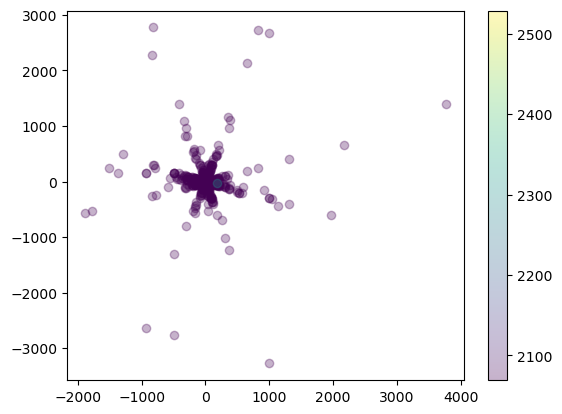

In [1303]:
b = torch.tensor([[1, 0]], dtype=torch.float64)
for idx, m in enumerate(walks):
    v = b@m[3]
    plt.scatter(v[0, 0], v[0, 1], c=idx, alpha=.3)
plt.colorbar()